Obtain forecasts for Trajectron on CARLA (or NuScenes) data.

In [1]:
%matplotlib inline

import os
import sys
sys.path.append('../../trajectron')
sys.path.append(f"{ os.environ['HOME'] }/code/robotics/carla-collect")
sys.path.append(f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg")

import pandas as pd
import numpy as np
import torch
import dill
import json
from glob import glob
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe

from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

class NumpyEncoder(json.JSONEncoder):
    """
    Custom encoder for numpy data types obtained from
    https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
    """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

In [2]:
# Search dataset
dataset_dir = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
glob(f"{ dataset_dir }/*/*.pkl")

['/home/fireofearth/code/robotics/carla-collect/carla_v3_dataset/carla_train_v3_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v3_dataset/carla_test_v3_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v3_dataset/carla_val_v3_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_train_v2_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_val_v2_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/out/20210712_16-14-19_dataset.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_val_v2_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_train_v2_1_full.pkl']

In [3]:
# Load dataset

# dataset_path = '../processed/nuScenes_test_full.pkl'
# dataset_path = f"{ dataset_dir }/carla_v2_dataset/carla_test_v2_full.pkl"
# dataset_path = f"{ dataset_dir }/carla_v2_1_dataset/carla_test_v2_1_full.pkl"
dataset_path = f"{ dataset_dir }/out/20210712_16-14-19_dataset.pkl"
with open(dataset_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
num_samples = 100
dataset_name = 'test'
t = 18
scene = eval_scenes[2]
ph = 8
timesteps = np.array([t])

In [127]:
t = 18
scene = eval_scenes[2]
ph = 8
timesteps = np.array([t])

### Combining forecast and map

In [4]:
# CARLA
dataset_name = 'CARLA'
t = 18
scene = eval_scenes[2]
ph = 8
timesteps = np.array([t])

In [38]:
# NuScenes
dataset_name = 'NuScenes'
t = 18
scene = eval_scenes[65]
ph = 8

timesteps = np.array([t])

In [5]:
node = scene.nodes[0]
df = scene_to_df(scene)
vars(node), df.columns

({'type': VEHICLE,
  'id': '98',
  'length': None,
  'width': None,
  'height': None,
  'first_timestep': 0,
  'non_aug_node': None,
  'data': <environment.data_structures.DoubleHeaderNumpyArray at 0x7ffa041329b0>,
  'is_robot': False,
  '_last_timestep': None,
  'description': '',
  'frequency_multiplier': 1,
  'forward_in_time_on_next_override': False},
 Index(['frame_id', 'node_id', 'position_x', 'position_y', 'velocity_x',
        'velocity_y', 'acceleration_x', 'acceleration_y', 'heading_x',
        'heading_y', 'heading_°', 'heading_d°', 'velocity_norm',
        'acceleration_norm'],
       dtype='object'))

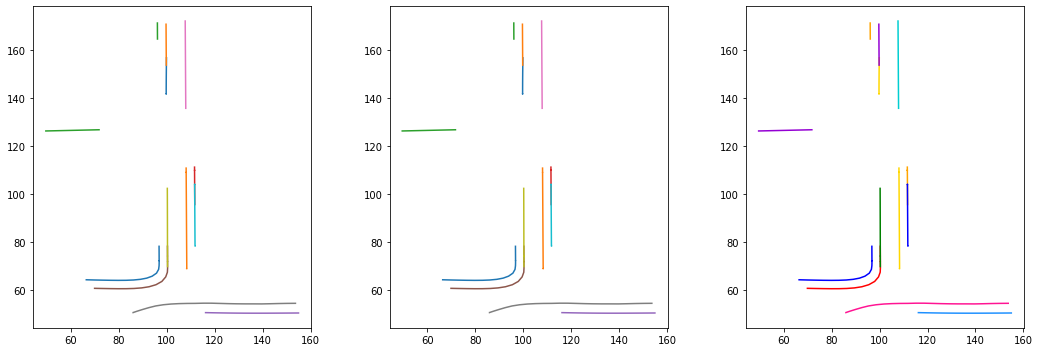

In [5]:
# Plotting dataset information
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.ravel()
ax = axes[0]
for node in scene.nodes:
    xy = node.data.data[:, :2]
    ax.plot(xy[:, 0], xy[:, 1])

ax = axes[1]
for node in scene.nodes:
    columns = ['_'.join(t) for t in node.data.header]
    df = pd.DataFrame(node.data.data, columns=columns)
    X = df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1])

ax = axes[2]
scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1], color=AGENT_COLORS[idx % NCOLORS])

for ax in axes:
    ax.set_aspect('equal')
fig.tight_layout()

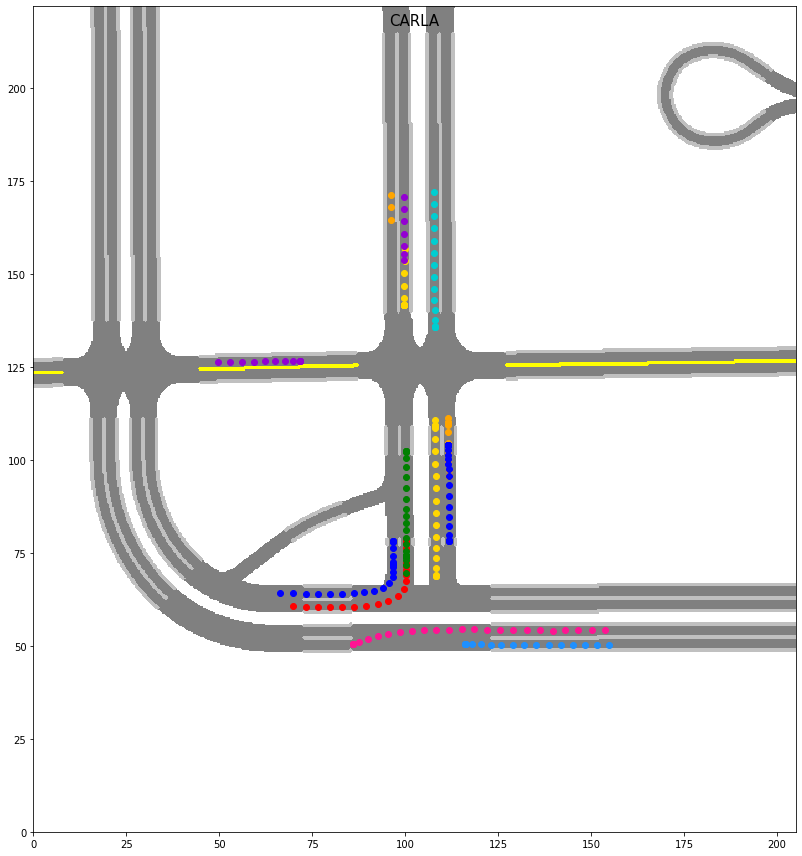

In [6]:
map_mask = scene.map['VEHICLE'].as_image()
# map_mask has shape (y, x, c)
road_bitmap = np.max(map_mask, axis=2)
road_div_bitmap = map_mask[..., 1]
lane_div_bitmap = map_mask[..., 2]

fig, ax = plt.subplots(figsize=(12,12))
extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
extent = (0, scene.x_size, 0, scene.y_size)
# Axes.imshow() expects (y, x, c)
ax.imshow(road_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'grey']))
ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()
fig.suptitle(dataset_name, fontsize=15)

scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values.T
    ax.scatter(X[0], X[1], color=AGENT_COLORS[idx % NCOLORS])

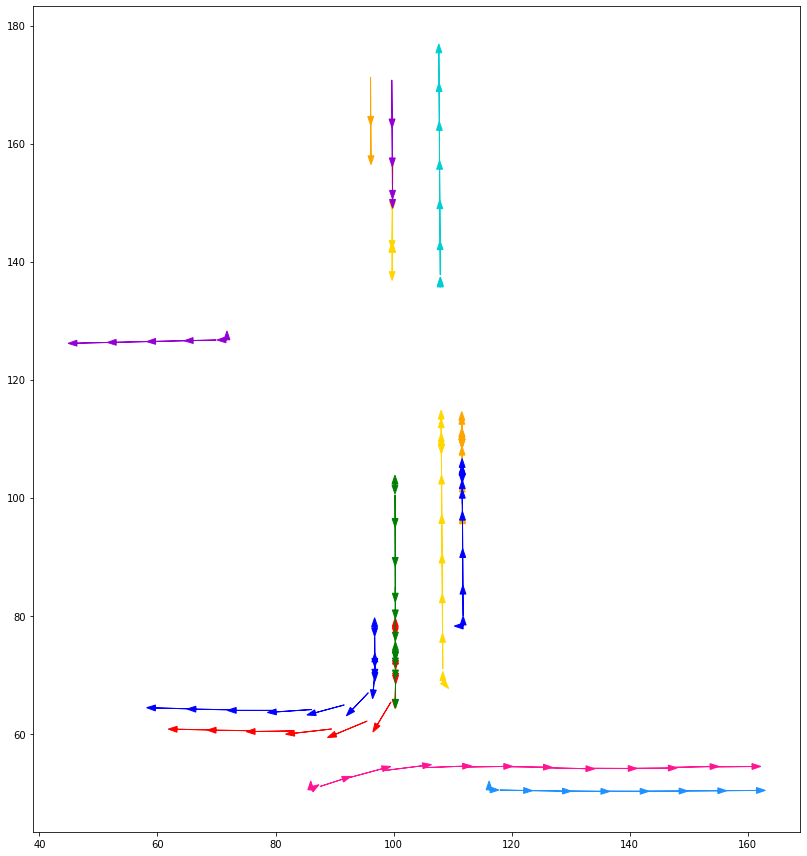

In [7]:
# Plot velocity
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()

scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values
    V = node_df[['velocity_x', 'velocity_y']].values
    n_subsample = 2
    start = 0
    for x, v in zip(X[start::n_subsample], V[start::n_subsample]):
        ax.arrow(x[0], x[1], v[0], v[1],
                head_width=1,
                color=AGENT_COLORS[idx % NCOLORS])


fig.tight_layout()
ax.set_aspect('equal')

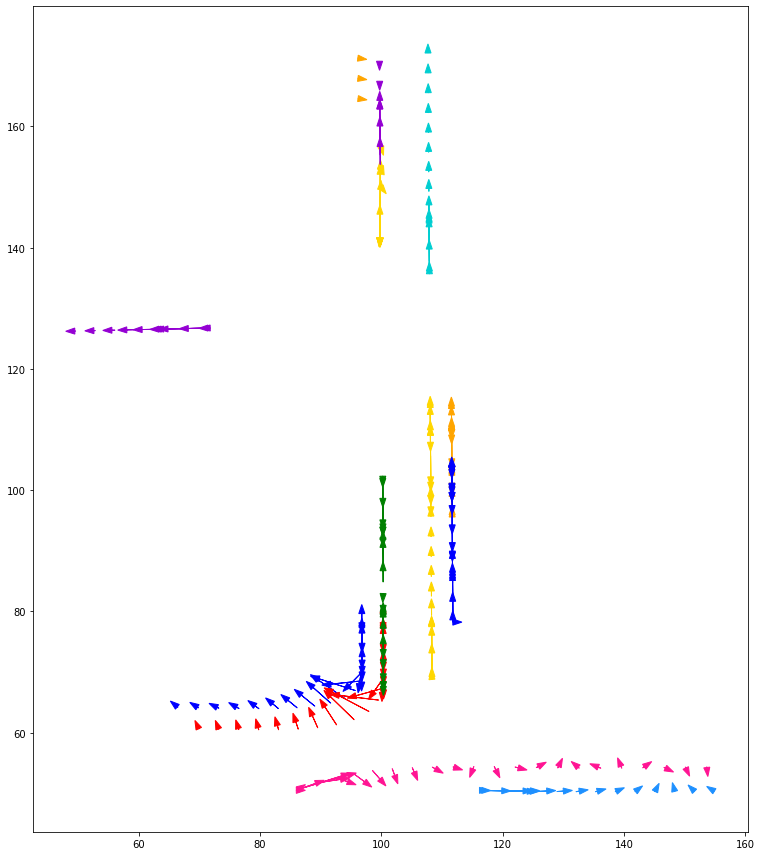

In [8]:
# Plot acceleration
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()

scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values
    A = 2 * node_df[['acceleration_x', 'acceleration_y']].values
    n_subsample = 1
    start = 0
    for x, a in zip(X[start::n_subsample], A[start::n_subsample]):
        ax.arrow(x[0], x[1], a[0], a[1],
                head_width=1,
                color=AGENT_COLORS[idx % NCOLORS])


fig.tight_layout()
ax.set_aspect('equal')

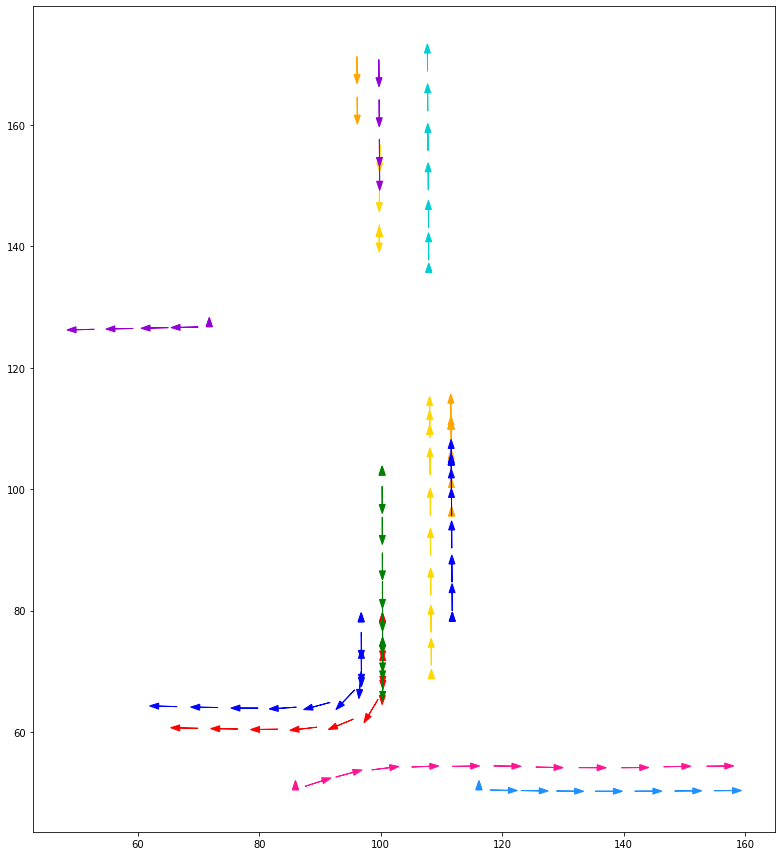

In [9]:
# Plot heading
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()

scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values
    H = 3 * node_df[['heading_x', 'heading_y']].values
    n_subsample = 2
    start = 0
    for x, h in zip(X[start::n_subsample], H[start::n_subsample]):
        ax.arrow(x[0], x[1], h[0], h[1],
                head_width=1,
                color=AGENT_COLORS[idx % NCOLORS])


fig.tight_layout()
ax.set_aspect('equal')

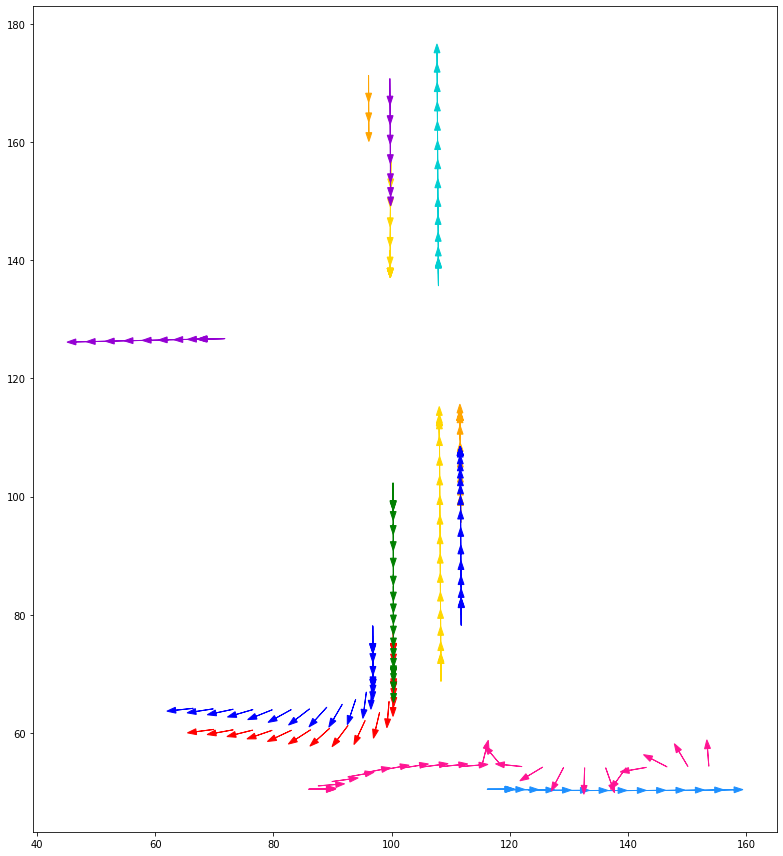

In [10]:
# Plot heading in degrees
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()

scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values
    hs = node_df['heading_°'].values
    cos_hs = 3 * np.cos(hs)
    sin_hs = 3 * np.sin(hs)
    n_subsample = 1
    start = 0
    for x, cos_h, sin_h in zip(X[start::n_subsample],
            cos_hs[start::n_subsample], sin_hs[start::n_subsample]):
        ax.arrow(x[0], x[1], cos_h, sin_h,
                head_width=1,
                color=AGENT_COLORS[idx % NCOLORS])


fig.tight_layout()
ax.set_aspect('equal')

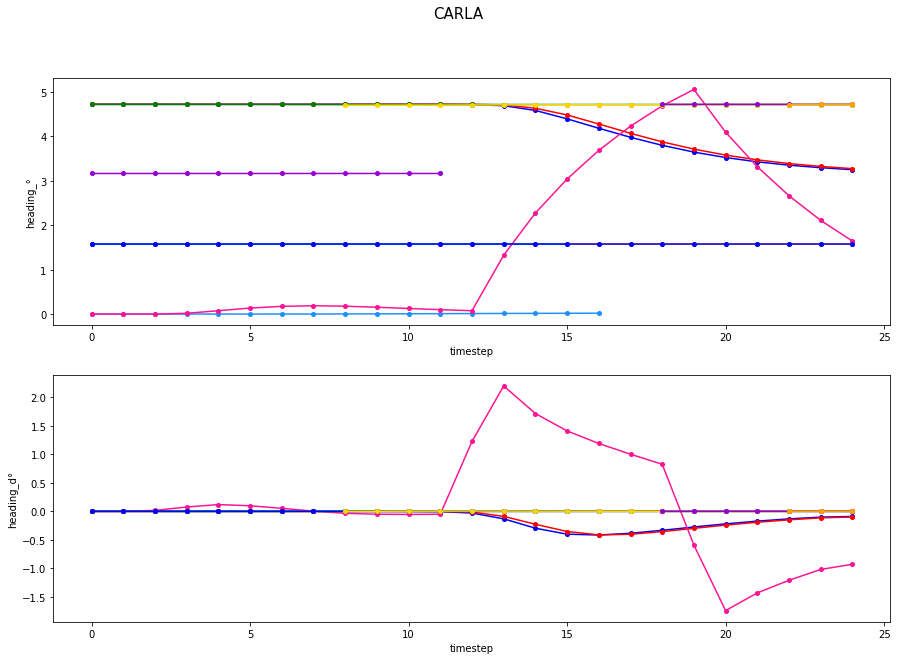

In [11]:
# Plot heading

scene_df = scene_to_df(scene)
fig, axes = plt.subplots(2, 1, figsize=(15,10))
axes = axes.ravel()

node_dict = {str(node.id): node for node in scene.nodes}
scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node = node_dict[node_id]
    node_df = scene_df[scene_df['node_id'] == node_id]
    Hd = node_df['heading_°'].values
    # heading_d° is the derivate of heading
    H = node_df['heading_d°'].values
    N = np.arange(node.first_timestep, node.first_timestep + len(node_df))
    axes[0].plot(N, Hd, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
    axes[1].plot(N, H, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)

axes[0].set_ylabel('heading_°')
axes[1].set_ylabel('heading_d°')
for ax in axes:
    ax.set_xlabel('timestep')
# fig.tight_layout()
fig.suptitle(dataset_name, fontsize=15)
None

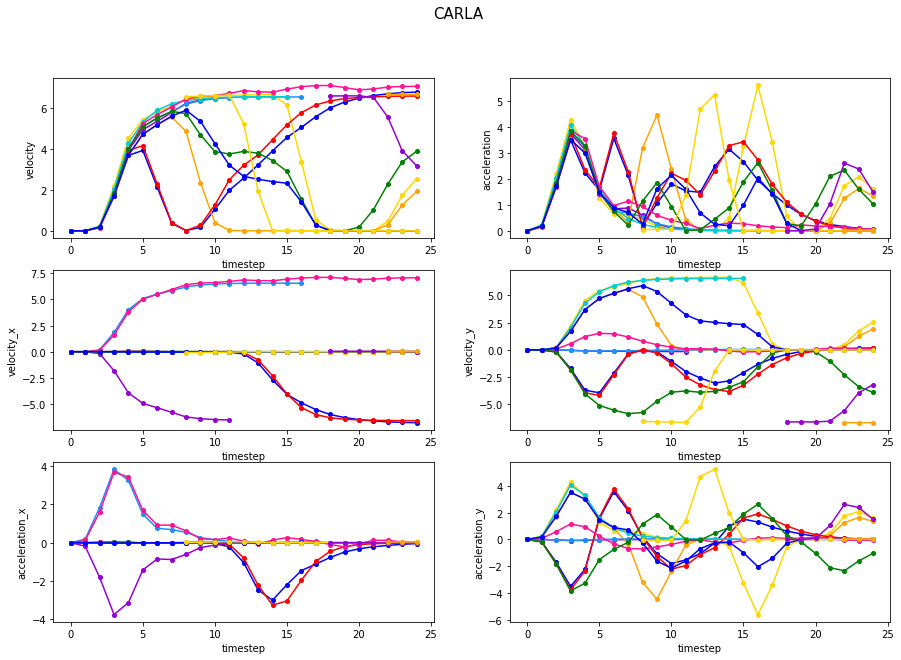

In [13]:
# Plot velocity and acceleration
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes = axes.ravel()

node_dict = {str(node.id): node for node in scene.nodes}
scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node = node_dict[node_id]
    node_df = scene_df[scene_df['node_id'] == node_id]
    Vnorm = node_df['velocity_norm'].values
    Anorm = node_df['acceleration_norm'].values
    X = node_df[['position_x', 'position_y']].values.T
    V = node_df[['velocity_x', 'velocity_y']].values.T
    A = node_df[['acceleration_x', 'acceleration_y']].values.T
    N = np.arange(node.first_timestep, node.first_timestep + len(node_df))
    axes[0].plot(N, Vnorm, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
    axes[1].plot(N, Anorm, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
    axes[2].plot(N, V[0], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
    axes[3].plot(N, V[1], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
    axes[4].plot(N, A[0], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
    axes[5].plot(N, A[1], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)

axes[0].set_ylabel('velocity')
axes[1].set_ylabel('acceleration')
axes[2].set_ylabel('velocity_x')
axes[3].set_ylabel('velocity_y')
axes[4].set_ylabel('acceleration_x')
axes[5].set_ylabel('acceleration_y')
for ax in axes:
    ax.set_xlabel('timestep')
# fig.tight_layout()
fig.suptitle(dataset_name, fontsize=15)
None